In [1]:
import kernel
import kernel_modified
import numpy as np
import fetch_data as fd
import alignment
import time
import MostFrequentFeatures as mff
import pylab as pb
import subprocess
import os
import sys
from tqdm import tqdm

In [2]:
def marcus_approximative_kernel_modified(x,z,s,n,lmda,cutoff = 1000):
    the_strings = b''
    if hash(tuple(x)) == hash(tuple(z)):
        equal_hash = b'1 '
    else:
        equal_hash = b'0 '
    the_args = bytes(str(len(x)),'ascii')+ b' ' + bytes(str(len(z)),'ascii')+ b' ' + bytes(str(len(s)),'ascii')+ b' '
    for i in x:
        the_strings = the_strings + bytes(i,'ascii')
        the_args = the_args + bytes(str(len(i)),'ascii') + b' '
    for i in z:
        the_strings = the_strings + bytes(i,'ascii')
        the_args = the_args + bytes(str(len(i)),'ascii') + b' '
    for i in s:
        the_strings = the_strings + bytes(i,'ascii')
        the_args = the_args + bytes(str(len(i)),'ascii') + b' '
    the_args = the_args + bytes(str(n), 'ascii')+ b' ' + bytes(str(lmda), 'ascii') + b' ' + bytes(str(cutoff), 'ascii')
    fast_kernel = subprocess.Popen(["./fast_approximative_kernel_modified.out"], stdin=subprocess.PIPE, stdout=subprocess.PIPE)
    output_test = fast_kernel.communicate(input=equal_hash+the_args+the_strings)[0]
#     print(output_test.decode('utf-8'))
    output_test_list = output_test.decode('utf-8').split()
    K = parseMatrix(output_test_list)
    return K

def marcus_approximative_kernel(x,z,s,n,lmda):
    the_strings = b''
    if hash(tuple(x)) == hash(tuple(z)):
        equal_hash = b'1 '
    else:
        equal_hash = b'0 '
    the_args = bytes(str(len(x)),'ascii')+ b' ' + bytes(str(len(z)),'ascii')+ b' ' + bytes(str(len(s)),'ascii')+ b' '
    for i in x:
        the_strings = the_strings + bytes(i,'ascii')
        the_args = the_args + bytes(str(len(i)),'ascii') + b' '
    for i in z:
        the_strings = the_strings + bytes(i,'ascii')
        the_args = the_args + bytes(str(len(i)),'ascii') + b' '
    for i in s:
        the_strings = the_strings + bytes(i,'ascii')
        the_args = the_args + bytes(str(len(i)),'ascii') + b' '
    the_args = the_args + bytes(str(n), 'ascii')+ b' ' + bytes(str(lmda), 'ascii')
    fast_kernel = subprocess.Popen(["./fast_approximative_kernel.out"], stdin=subprocess.PIPE, stdout=subprocess.PIPE)
    output_test = fast_kernel.communicate(input=equal_hash+the_args+the_strings)[0]
#     print(output_test.decode('utf-8'))
    output_test_list = output_test.decode('utf-8').split()
    K = parseMatrix(output_test_list)
    return K

def parseMatrix(matrix):
    num_rows = int(matrix[0])
    num_cols = int(matrix[1])
    K = np.zeros([num_rows,num_cols])
    counter = 2
    for i in range(num_rows):
        for j in range(num_cols):
            K[i,j] = float(matrix[counter])
            counter = counter + 1
    return K

def marcus_mostFrequentFeatures(dataset, k, numbTop,prints = False):
#     the_long_string = ''
    list_of_features = []
    for i in tqdm(dataset):
#         the_long_string += i
        the_len = len(i)
        for j in range(the_len-k+1):
            curr_str = i[j:j+n]
            if not curr_str in list_of_features:
                list_of_features.append(curr_str)
    scores = np.zeros(len(list_of_features))
    for index, feature in tqdm(enumerate(list_of_features)):
        for i in dataset:
            scores[index] += i.count(feature)
    topFeatures = []
    topFeatureScores =  []
    scores = scores.argsort()[-len(scores):][::-1]
    features = np.array(list_of_features)
    topFeatures = features[scores][:numbTop]
    topFeatureScores = scores[:numbTop]
    return topFeatures, topFeatureScores

In [3]:
#categories = ['earn','acq']
#numberOfTraining = [10,10]
#numberOfTesting = [1,1]

#trainData,trainLabels, testData,testLabel = fd.loadData(categories,numberOfTraining,numberOfTesting)
n=3
l=0.05
S = 500;
loopVec = np.arange(0,2400,100);

trainData = fd.nrData(100,shuffle=False)
topFeatures, topFeatureScores = marcus_mostFrequentFeatures(trainData,n,S)

for j in [10]:
    c=0;
    for i in range(0,20):

        timeOld = [];
        timeNew = [];
        frobVal = [];
        timeRel = [];
        d=0;
        c+=1;
        print("Iteration: " + repr(c) + " of " + repr(20));
        
        for cutoff in loopVec:
            d += 1;
            sys.stdout.flush()
            sys.stdout.write("Iteration: " + repr(d) + " of " + repr(len(loopVec)) + " \r");
            
            t1=time.time()
            K = marcus_approximative_kernel(trainData,trainData,topFeatures,n,j/100);
            t2=time.time()
            timeOld.append(t2-t1);
            
            t3=time.time()
            K_mod = marcus_approximative_kernel_modified(trainData,trainData,topFeatures,n,j/100,cutoff);
            t4=time.time()
            timeNew.append(t4-t3);
            
            timeRel.append((t2-t1)/(t4-t3))
            
            frobVal.append(alignment.alignment(K,K_mod));

        cwd = os.getcwd()+'\..\data\modified_approx_kernel_data';
        kerns = os.path.join(cwd,"l{}n{}frobVal_{}.npy".format(j,n,i))
        np.save(kerns,frobVal)
        kerns = os.path.join(cwd,"l{}n{}newTime_{}.npy".format(j,n,i))
        np.save(kerns,timeNew)
        kerns = os.path.join(cwd,"l{}n{}oldTime_{}.npy".format(j,n,i))
        np.save(kerns,timeOld)
        kerns = os.path.join(cwd,"l{}n{}relTime_{}.npy".format(j,n,i))
        np.save(kerns,timeRel)
        

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 122.73it/s]
3498it [00:00, 9245.06it/s]


Iteration: 1 of 20
Iteration: 2 of 204 
Iteration: 3 of 204 
Iteration: 4 of 204 
Iteration: 5 of 204 
Iteration: 6 of 204 
Iteration: 7 of 204 
Iteration: 8 of 204 
Iteration: 9 of 204 
Iteration: 10 of 20 
Iteration: 11 of 20 
Iteration: 12 of 20 
Iteration: 13 of 20 
Iteration: 14 of 20 
Iteration: 15 of 20 
Iteration: 16 of 20 
Iteration: 17 of 20 
Iteration: 18 of 20 
Iteration: 19 of 20 
Iteration: 20 of 20 


In [32]:
timeRel = [];
for i,t in enumerate(timeNew):
    timeRel.append(timeOld[0]/t);

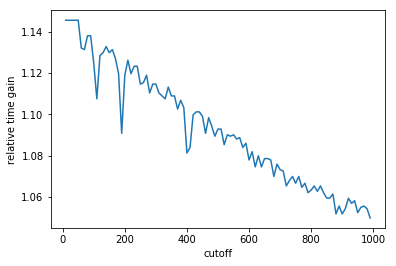

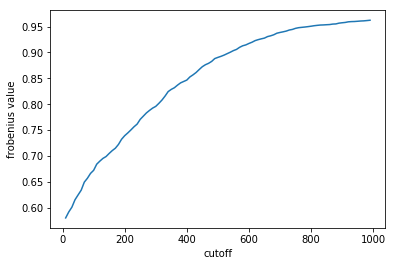

In [33]:
pb.plot(loopVec,timeRel);
pb.xlabel("cutoff")
pb.ylabel("relative time gain")
pb.show()

pb.figure()
pb.plot(loopVec,frobVal);
pb.xlabel("cutoff")
pb.ylabel("frobenius value")
pb.show()

In [16]:
print(loopVec[23])
print(frobVal[23])
print(timeNew[23])
print(timeOld[23])

500
0.88488092904
43.839754819869995
72.31045174598694
